# ForceSMIP Minimal Example: Fingerprinting

By: Stephen Po-Chedley and Celine Bonfils (based on work by Ben Santer)

Suggestions and Improvements Welcome!

The goal of this notebook is to use a traditional pattern-based climate fingerprinting technique to determine if the trend in atmospheric temperature change is attributable to human influence. This method is derived from a statistical framework conceptualized in by Klaus Hasselmann ([Hasselmann 1979](https://pure.mpg.de/rest/items/item_3030122_6/component/file_3030123/content)) and further developed by Benjamin Santer (e.g., in [Santer et al 2023](https://www.pnas.org/doi/10.1073/pnas.2300758120)) at LLNL. It relies on the principle that external forcings and climate noise imprint on the Earth’s climate with very different spatial patterns.

The technique first determines the “fingerprint,” which is the spatial pattern of changes expected in response to the external forcings as derived from the long-term historical temperature change in climate models. The fingerprint is calculated as the leading empirical orthogonal function (EOF) of the multimodel average annual-mean anomalies in temperature. This spatial mode is then projected onto observations to produce an observed "signal" time series which is a measure of the spatial similarity between the observations and the fingerprint. The mode is also projected onto model data from unforced simulations (or, in this notebook, model simulations from which the forced component has been removed) to produce a “noise” time series. This noise time series is sampled many times (across models, model realizations, and time periods) and a distribution of noise trends is calculated. The standard deviation of this sample of noise trends (N) is then compared to the trend existing in the signal time series (S). The signal-to-noise ratio (S/N) is then used to estimate whether the signal trend is significantly larger than what can be produced from internal variability (e.g., S ≥ 2$\sigma_{\mathrm{noise}}$)

This signal-to-noise (S/N) calculation can be done as a function of time period (e.g., 1950 – 1959, 1950 - 1960, 1950, 1961, ..., 1950 - 2022) to determine the date at which the signal emerges from the noise.

#### Outline:

* Setup notes
* Import packages and set user parameters
* Load data
    * Load evaluation data to compute mask
    * Load training data
* Compute fingerprint
* Compute/plot noise time series and trends
* Load evaluation data and compute/plot signal time series and trends
* Show large signal-to-noise ratios in evaluation data

## Some setup notes

This setup assumes that you have anaconda installed. If you do not, you can install miniconda (from [here](https://docs.conda.io/en/main/miniconda.html)).

To create this environment we ran `conda create -n forcesmip -c conda-forge xcdat xesmf scikit-learn scipy eofs matplotlib cartopy nc-time-axis ipython ipykernel`

> Note: You may need to check your shell activate conda. To determine your shell, you can run `echo $SHELL`. You can then activate conda (based on your shell type, e.g., `conda init bash`). You may then need to subsequently re-source your shell (e.g., `source ~/.bashrc` for bash).

Activate your environment with: `conda activate forcesmip`

> Note: Alternatively, you can try `source activate forcesmip`

If you'd like to be able to use this environment with Jupyter, you need to install it with:

`python -m ipykernel install --user --name forcesmip --display-name forcesmip`

### Import packages

In [1]:
# I/O and data wrangling
import time as clocktime
import glob
import xcdat as xc
import xarray as xr
import numpy as np

# principal component analysis
from eofs.xarray import Eof

# plotting
import matplotlib.pyplot as plt

# define a lambda function to perform natural sort
import re
natsort = lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split("(\d+)", s)]

### Define some static mappings for CMIP/ForceSMIP data

This is just some helper information to helps us search for data and reshape it. All ForceSMIP data is on a 2.5 x 2.5 degree lat/lon grid. 

In [2]:
cmipTable = {
    "pr": "Amon",
    "psl": "Amon",
    "tas": "Amon",
    "zmta": "Amon",
    "tos": "Omon",
    "siconc": "OImon",
    "monmaxpr": "Aday",
    "monmaxtasmax": "Aday",
    "monmintasmin": "Aday",
}
cmipVar = {
    "pr": "pr",
    "psl": "psl",
    "tas": "tas",
    "zmta": "ta",
    "tos": "tos",
    "siconc": "siconc",
    "monmaxpr": "pr",
    "monmaxtasmax": "tasmax",
    "monmintasmin": "tasmin",
}
nlat = 72
nlon = 144

### User options

Set some options on data location, variable of interest, analysis period, etc.

In [3]:
# User parameters
root_dir = "/glade/campaign/cgd/cas/asphilli/ForceSMIP/"  # directory of ForceSMIP data on the machine you're using
ncvar = "zmta"  # variable to be used: pr, psl, tas, zmta, tos, siconc, monmaxpr, monmaxtasmax, monmintasmin
vid = cmipVar[ncvar]  # the variable id in the netcdf file differs – this maps to the standard CMIP variable name
reference_period = ("1950-01-01", "1999-12-31") # climatological period (for anomaly calculations)

# choose evaluation data
eval_tier = "Tier1"  # Tier1, Tier2, or Tier3
tv_time_period = ("1950-01-01", "2022-01-01")

### Load in evaluation data

The evaluation data has some missing data. Here we load the evaluation data to ensure that a common mask is used for both training and evaluation data.

In [4]:
# get evaluation models
eval_dir = root_dir + '/Evaluation-' + eval_tier + '/' + cmipTable[ncvar] + '/' + ncvar
eval_models = glob.glob(eval_dir + '/*')
eval_models = [p.split('_')[-1].split('.')[0] for p in eval_models]
eval_models.sort(key=natsort)

# initialize output dataset
eval_model_climatology = None
# We also will define a reference plev (used to ensure all models are on the same plev axis)
ref_plev = None

# loop over evaluation models
for model in eval_models:
    # get file for model
    fn = glob.glob(eval_dir + '/*_' + model + '.*.nc')
    # make sure filename is unique
    if len(fn) != 1:
        raise ValueError("Unexpected number of model members")
    else:
        fn = fn[0]
    # open dataset
    ds = xc.open_dataset(fn)
    # remove singletons
    ds = ds.squeeze()
    # compute annual average temperature values
    ds = ds.temporal.group_average(vid, freq='year')
    # subset data to user-specified time period
    ds = ds.sel(time=slice(tv_time_period[0], tv_time_period[1]))
    # get the reference pressure level if it doesn't exist
    if ref_plev is None:
        ref_plev = ds.plev.copy(deep=True)
    # Some datasets have plev data that is off by 1E-7 relative to the fingerprint. 
    # This causes issues with xarray. We head this problem off here. 
    plev_not_equal = np.sum((ds.plev.values  - ref_plev.values) < 1e-6) > 0
    plev_all_close = np.alltrue((ds.plev.values  - ref_plev.plev.values) < 1e-6)
    if (plev_not_equal & plev_all_close):
        ds.coords['plev'] = ref_plev
    # get average values at each grid point
    ds = ds.mean(dim='time', skipna=False)
    # add dataset to evaluation climatology dataset
    if eval_model_climatology is None:
        eval_model_climatology = ds
    else:
        eval_model_climatology = xr.concat((eval_model_climatology, ds), dim='model')

# now compute multi-model mean (this will be used to mask out missing values)
eval_model_climatology = eval_model_climatology.mean(dim='model', skipna=False)

### Load training data

We will load in atmospheric temperature data from the ForceSMIP training data in order to calculate the multimodel mean changes in atmospheric temperature. We will also compute the fluctuations in atmospheric temperature that arise from internal variability alone, by removing the ensemble mean component of atmospheric temperature change from individual ensemble members. The former will be used to calculate the "human fingerprint" – the pattern of changes expected from human influence on climate. We can then project this fingerprint onto fluctuations of atmospheric temperature that arise from internal climate variability alone (e.g., the "noise").

Note that, for each model, the original data (after computing the annual average) consist in 17 pressure levels x  72 latitudes and 72 yearly time samples for the 1950-2022 period. For each model, we will compute the latitude-height “ensemble mean” atmospheric temperature time series by averaging the ensemble members together. For each model, we will then subtract this “ensemble mean” time series from each ensemble member to produce estimates of the internally-generated "unforced" atmospheric temperature time series for that model.

This information will be saved in a directory called `./data/` for subsequent analysis. We subsequently will compute the multimodel mean time series by averaging the “ensemble mean” time series together.

In [5]:
# get training models
files = glob.glob(root_dir + '/Training/' + cmipTable[ncvar] + '/' + ncvar + '/*')
models = [p.split('/')[-1] for p in files]

# initialize a list to store model ensemble mean time series
model_mean_list = []

# loop over training models
for imodel, model in enumerate(models):
    # start timer
    stime = clocktime.time()
    # get model files
    mpath = root_dir + '/Training/' + cmipTable[ncvar] + '/' + ncvar + '/' + model
    mfiles = glob.glob(mpath + '/*')
    # parse file names to get list of model members
    # CESM2 has a non-CMIP naming convention
    if model == "CESM2":
        members = [p.split("ssp370_")[-1].split(".1880")[0] for p in mfiles]
    else:
        members = [p.split("_")[-1].split(".")[0] for p in mfiles]
    members.sort(key=natsort)
    # print progress
    print(str(imodel + 1) + " / " + str(len(models)) + ": " + model + " (" + str(len(members)) + " members)")
    # initialize model ensemble xarray dataset
    ds_model = None
    for im, member in enumerate(members):
        # print member progress
        print('.', end='')
        # get member filename
        fn = glob.glob(mpath + "/*_" + member + ".*.nc")
        # make sure filename is unique
        if len(fn) != 1:
            raise ValueError("Unexpected number of model members")
        else:
            fn = fn[0]
        # load data
        ds = xc.open_dataset(fn)
        # remove singletons / lon
        ds = ds.squeeze()
        ds = ds.drop_vars('lon')
        # # check if there are unexpected missing values  STEVE
        # nm = len(np.where(np.isnan(ds.ta[:, 5, 36]))[0])
        # we will skip realizations with unexpected missing data
        # if nm > 0:
        #     continue
        # subset data to user-specified time period
        ds = ds.sel(time=slice(tv_time_period[0], tv_time_period[1]))
        # calculate departures (relative to user-specified reference time period)
        ds = ds.temporal.departures(vid, freq='month', reference_period=reference_period)
        # compute annual average temperature values
        ds = ds.temporal.group_average(vid, freq='year')
        # # This block is to ensure all models have the same time axis since
        # # we are concatenating models/members to the same xarray dataset.
        # # Even if time steps are the same, differing calendars can create problems
        # # during concatenation.
        # #
        # get reference time axis if it does not exist
        if 'ref_time' not in locals():
            ref_time = ds.time
        # validate model/member time is the same as reference time
        for i, t in enumerate(ds.time.values):
            m = t.month; y = t.year
            rt = ref_time.values[i]; rm = rt.month; ry = rt.year
            if ((ry != y) | (rm != m)):
                raise ValueError("model time and reference time do not match")
        # set model/member time to reference time
        ds["time"] = ref_time.copy()
        # add model realization to model ensemble dataset
        if ds_model is None:
            ds_model = ds
        else:
            ds_model = xr.concat((ds_model, ds), dim='member')
    # after looping over members, compute model ensemble mean time series
    ds_model_mean = ds_model.mean(dim='member', skipna=False)
    # calculate model anomaly values
    ds_model_anomaly = ds_model - ds_model_mean
    # save unforced anomaly values for "noise" calculations
    fnOut = 'data/' + ncvar + '_' + model + '_unforced.nc'
    ds_model_anomaly.to_netcdf(fnOut)
    # concatenate model ensemble mean to list
    model_mean_list.append(ds_model_mean.load())
    del ds_model, ds_model_mean, ds_model_anomaly
    # print time elapse for model
    etime = clocktime.time()
    print()
    print("Time elapsed: " + str(etime - stime) + " seconds")
    print()

# concatenate model means together
# this will be used to produce the multimodel mean time series
ds_multi_model = xr.concat(model_mean_list, dim='model')

1 / 5: MPI-ESM1-2-LR (30 members)
..............................
Time elapsed: 21.344719648361206 seconds

2 / 5: CanESM5 (25 members)
.........................
Time elapsed: 16.940051555633545 seconds

3 / 5: MIROC-ES2L (30 members)
..............................
Time elapsed: 21.845887184143066 seconds

4 / 5: MIROC6 (50 members)
..................................................
Time elapsed: 35.070643186569214 seconds

5 / 5: CESM2 (50 members)
..................................................
Time elapsed: 25.39406943321228 seconds



### Solve for Fingerprint

In the above loop, we have stored each model's ensemble mean time series in the `ds_multi_model` dataset. We now average over all the models together to obtain the multi-model ensemble mean timeseries. We then perform principal component analysis to determine the leading mode of temperature variablity over the historical time period. This leading EOF is considered the "fingerprint" latitude-height pattern, which is the basis for subsequent calculations. In calculating the fingerprint, we weight the data to account for area variations in different latitude bands. 

In [6]:
# compute multimodel mean time series
ds_multi_model_mean = ds_multi_model.mean(dim='model', skipna=False)
# get the latitude weights
ds_multi_model_mean = ds_multi_model_mean.bounds.add_missing_bounds()
lat_weights = ds_multi_model_mean.spatial.get_weights(axis=['Y'])
# mask missing data in evaluation dataset (so they are consistent)
ds_multi_model_mean['ta'] = xr.where(~np.isnan(eval_model_climatology.ta), ds_multi_model_mean.ta, np.nan)
ds_multi_model_mean['ta'] = ds_multi_model_mean['ta'].transpose('time', 'plev', 'lat')
# load PCA solver and compute EOFs and PCs
solver = Eof(ds_multi_model_mean.ta, weights=lat_weights)
pcs = solver.pcs(npcs=5, pcscaling=0)
eofs = solver.eofs(neofs=5)

### Show fingerprint

Here we show the fingerprint, which is similar to that of [Santer et al. (2023)](https://www.pnas.org/doi/10.1073/pnas.2300758120). Unsurprisingly, the fingerprint exhibits stratospheric cooling and tropospheric warming (with enhanced warming in the tropical upper troposphere and near the Arctic surface). 

Text(0.5, 1.0, 'Fingerprint Pattern (EOF1) [91.1% variance explained]')

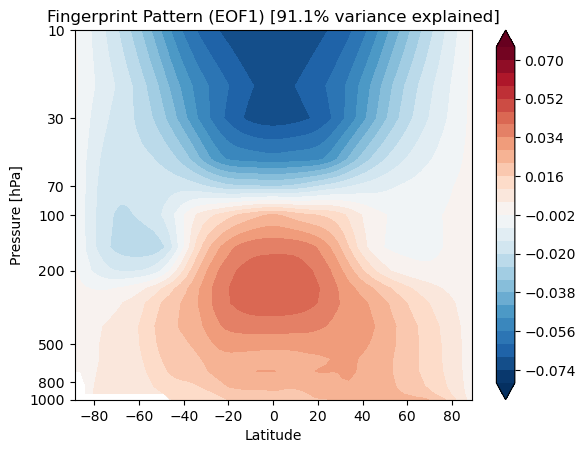

In [7]:
# get eof1
eof1 = eofs.isel(mode=0)
# get the axis information for plotting
lat = eof1.lat
plev = eof1.plev
# specify color intervals
clevs = np.arange(-0.08, 0.08, 0.006)
# contour lat-height map
plt.contourf(lat, np.log(plev), eof1, clevs, cmap=plt.cm.RdBu_r, extend='both')
# reverse y-axis so high pressure (surface) is at the bottom
plt.gca().invert_yaxis()
# specify vertical tick locations
plevticks = np.array([10, 30, 70, 100, 200, 500, 800, 1000])
plt.yticks(ticks=np.log(plevticks*100), labels=plevticks)
# add labels
plt.xlabel('Latitude')
plt.ylabel('Pressure [hPa]')
# add colorbar
plt.colorbar()
# add a title (with the variance explained)
var_exp = solver.varianceFraction().values[0]
ve = str(np.round(var_exp*100., 1))
plt.title('Fingerprint Pattern (EOF1) [' + ve + '% variance explained]')

### Get "noise" time series

Next, we project the EOF (aka fingerprint) above onto the pre-calculated time series of unforced atmospheric temperature variability (recall that we computed and saved these time series in the `data` directory earlier). The resulting PCs have large magnitudes when internally-generated temperature anomalies produce spatial patterns that are similar to the above fingerprint by chance.

In [8]:
# initialize output dictionary
unforced_pc_timeseries = {}
# loop over models
for model in models:
    print(model)
    # pre-allocate dict space for each model
    unforced_pc_timeseries[model] = {}
    # load in the unforced model atmospheric temperature time series (produced above)
    fn = 'data/' + ncvar + '_' + model + '_unforced.nc'
    # open dataset - using xarray to avoid a warning about missing unit attributes
    ds = xr.open_dataset(fn, use_cftime=True)
    # mask data that is missing in the multimodel mean to ensure a common mask
    ds = ds.where(~np.isnan(ds_multi_model_mean.ta), np.nan)
    # loop over each model member
    for i in range(len(ds.member)):
        # project fingerprint onto the ta time series for each member
        pseudo_pcs = solver.projectField(ds.ta[i])
        # get the leading PC (noise time series)
        ts_noise = pseudo_pcs[:, 0]
        # store resulting PC in dictionary
        unforced_pc_timeseries[model][i] = ts_noise
    # clean up
    ds.close()

MPI-ESM1-2-LR
CanESM5
MIROC-ES2L
MIROC6
CESM2


### Plot example noise time series

Text(0.5, 1.0, 'Example Noise Time Series (CESM2)')

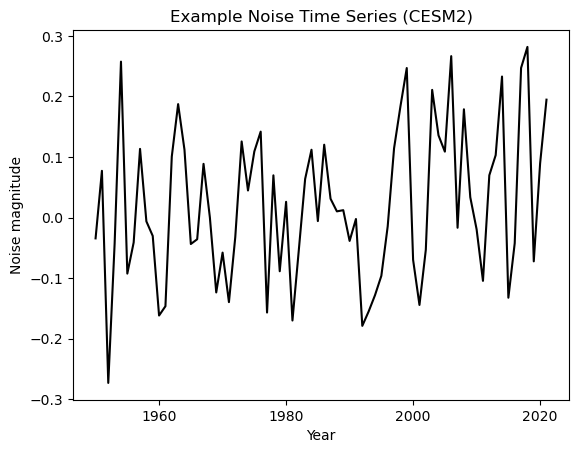

In [9]:
# Show example noise time series
unforced_pc_timeseries[model][0].plot(color='k')
plt.ylabel('Noise magnitude')
plt.xlabel('Year')
plt.title('Example Noise Time Series (' + model + ')')

### Get noise distribution as a function of timescale

It is of interest to analyze signal trends in atmospheric temperature and how they compare to internally-generated trends. To do this, we first compute the unforced trends in the noise time series computed above using different trend lengths (5 to 50 years). We perform this calculation over all members of all models (using non-overlapping time intervals).

In [10]:
# set time scales 5 years onward
timescales = np.arange(5, len(ts_noise))
# initialize noise time series dictionary
noise = {}
# loop over timescales
for nyears in timescales:
    # initialize list of noise trends
    it_noise = []
    # loop over models
    for model in models:
        # get model members
        members = list(unforced_pc_timeseries[model].keys())
        # loop over model memebrs
        for member in members:
            # get pre-computed noise PC time series
            ts = unforced_pc_timeseries[model][member]
            # get time axis
            time = np.array([t.year for t in ts.time.values])
            # get the number of non-overlapping time windows
            nsamples = int(np.floor(len(ts) / nyears))
            # loop over the time windows (trend time periods)
            for ns in range(nsamples):
                # get time interval indices
                sample_inds = np.arange(ns*nyears, ns*nyears+nyears)
                # subset time series
                ts_sub = ts.isel(time=sample_inds)
                # compute trend
                m, b = np.polyfit(time[sample_inds], ts_sub, 1)
                # add trend to list
                it_noise.append(m)
    # add list to noise dictionary
    noise[nyears] = it_noise

### Show distribution of noise trends at select timescales

We expect that internally-generated climate variations get smaller with longer time scales. We see that here in the distribution of non-overlapping noise time series trends (for trend lengths of 10, 25, and 50 years). As expected, there is a pronounced decrease in the noise amplitude on longer timescales.

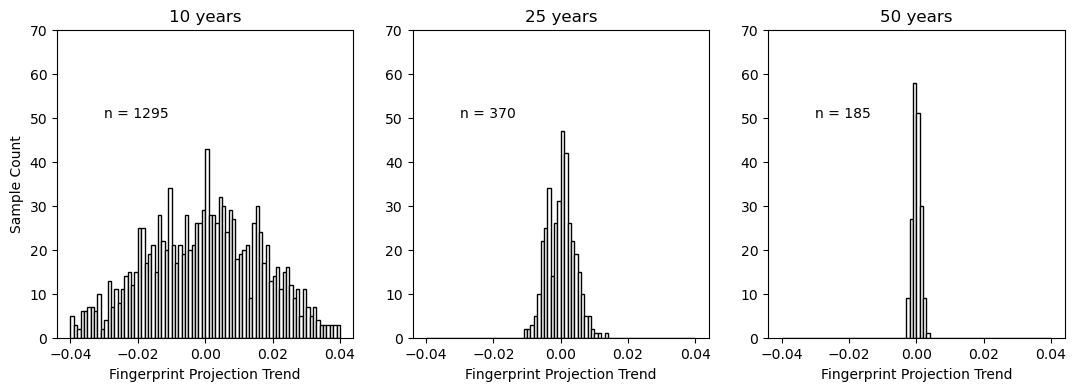

In [11]:
plt.figure(figsize=(13, 4))
x = np.arange(-0.04, 0.041, 0.001)
for i, nyears in enumerate([10, 25, 50]):
    plt.subplot(1, 3, i+1)
    plt.hist(noise[nyears], bins=x, fc='w', ec='k')
    plt.title(str(nyears) + ' years')
    plt.text(-0.03, 50, 'n = ' + str(len(noise[nyears])))
    plt.ylim(0, 70)
    plt.xlabel('Fingerprint Projection Trend')
    if i == 0:
        plt.ylabel('Sample Count')

### Show decay of noise with time

From the histogram above we see that the amplitude of trends in the noise time series gets smaller with longer timescales. We visualize this below by plotting the standard deviation of noise trends as a function of trend length. 

Text(0.5, 0, 'Timescale [Years]')

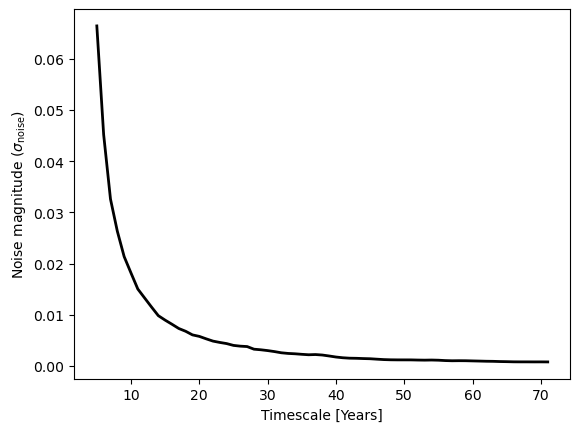

In [12]:
# initialize trend standard deviation list
y = []
# loop over time intervals and append standard deviation of trends
for p in timescales:
    y.append(np.std(noise[p]))

# plot data
plt.plot(timescales, y, color='k', linewidth=2)
plt.ylabel('Noise magnitude ($\sigma_{\mathrm{noise}}$)')
plt.xlabel('Timescale [Years]')

### Get signal time series

We will now focus on the signal time-series. To do this, fingerprinting studies typically project the human fingerprint pattern onto observations to measure the similarity between the expected fingerprint and the observed spatial patterns. The resulting time series (also called pseudo principal components) display the temporal evolution of the model-produced fingerprint in real-world data. Here, we project the fingerprint onto the “evaluation” data to emulate this step (one of the datasets is observations!).

In [13]:
# get evaluation models
eval_dir = root_dir + '/Evaluation-' + eval_tier + '/' + cmipTable[ncvar] + '/' + ncvar
eval_models = glob.glob(eval_dir + '/*')
eval_models = [p.split('_')[-1].split('.')[0] for p in eval_models]
eval_models.sort(key=natsort)

# initialize forced pc time series
forced_pc_timeseries = {}
# loop over evaluation models
for model in eval_models:
    # get model filename
    fn = glob.glob(eval_dir + '/*_' + model + '.*.nc')
    # make sure filename is unique
    if len(fn) != 1:
        raise ValueError("Unexpected number of model members")
    else:
        fn = fn[0]
    # open dataset
    ds = xc.open_dataset(fn)
    # remove singletons
    ds = ds.squeeze()
    # subset data to user-specified time period
    ds = ds.sel(time=slice(tv_time_period[0], tv_time_period[1]))
    # compute departures relative to user-specified base period
    ds = ds.temporal.departures(vid, freq='month', reference_period=reference_period)
    # get annual average values
    ds = ds.temporal.group_average(vid, freq='year')
    # Some datasets have plev data that is off by 1E-7 relative to the fingerprint. 
    # This causes issues with xarray. We head this problem off here. 
    plev_not_equal = np.sum((ds.plev.values  - ds_multi_model_mean.plev.values) < 1e-6) > 0
    plev_all_close = np.alltrue((ds.plev.values  - ds_multi_model_mean.plev.values) < 1e-6)
    if (plev_not_equal & plev_all_close):
        ds.coords['plev'] = ds_multi_model_mean.plev
    # # This block is to ensure all models have the same time axis since
    # # we are concatenating models/members to the same xarray dataset
    # # even if time steps are the same differing calendars can create problems
    # # during concatenation
    # #
    # validate model/member time is the same as reference time
    for i, t in enumerate(ds.time.values):
        m = t.month; y = t.year
        rt = ref_time.values[i]; rm = rt.month; ry = rt.year
        if ((ry != y) | (rm != m)):
            print(ry, rm, y, m)
            raise ValueError("model time and reference time do not match")
    ds["time"] = ref_time.copy()
    try:
        # mask data that is missing in the multimodel mean to ensure a common mask
        ds = ds.where(~np.isnan(ds_multi_model_mean.ta), np.nan)
        # compute and store fingerprint PC time series
        pseudo_pcs = solver.projectField(ds.ta)
        pc1 = pseudo_pcs[:, 0]
        forced_pc_timeseries[model] = pc1
    except:
        print('issue with ' + model)
        continue

### Plot signal time series

Here we plot the pseudo-principal component, which is large when the human fingerprint strongly projects onto the temperature anomalies from the evaluation dataset.

Text(0.5, 0, 'Year')

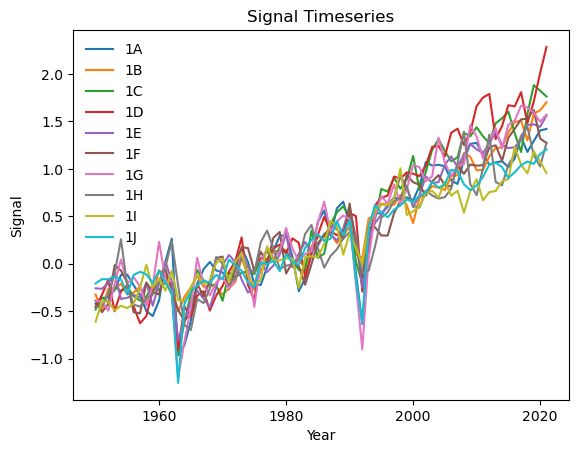

In [14]:
# loop over models to plot PC
for model in forced_pc_timeseries.keys():
    forced_pc_timeseries[model].plot(label=model)
plt.legend(frameon=False)
plt.title('Signal Timeseries')
plt.ylabel('Signal')
plt.xlabel('Year')

### Get signal trend as a function of timescale

We want to compute the trend in the PC time series (i.e., the signal) as a function of time scale. The trends can then be compared to the distribution of unforced PC trends (e.g., the noise) to determine if the signal is large compared to the noise. 

In [15]:
# initialize dictionary to hold signal trends
signal = {}
# loop over evalution models
for model in forced_pc_timeseries.keys():
    # pre-allocate nested signal dict for model
    signal[model] = {}
    # get the pre-compute forced PC time series
    pc1 = forced_pc_timeseries[model]
    # loop over each timescale to compute the PC trend
    for nyears in timescales:
        # get indices for time scale
        sample_inds = np.arange(0, nyears)
        # compute the trend
        m, b = np.polyfit(time[sample_inds], pc1.isel(time=sample_inds), 1)
        # store the trend (signal)
        signal[model][nyears] = m

# get end years for plotting purposes
end_year = []
for nyears in timescales:
    end_year.append(time[0] + nyears - 1)

### Plot signal trend as a function of timescale

Now we show how the trend in the forced fingerprint time series grows with length (from the start of the time interval through the end year). 

Text(0, 0.5, 'Signal Trend (1950 - )')

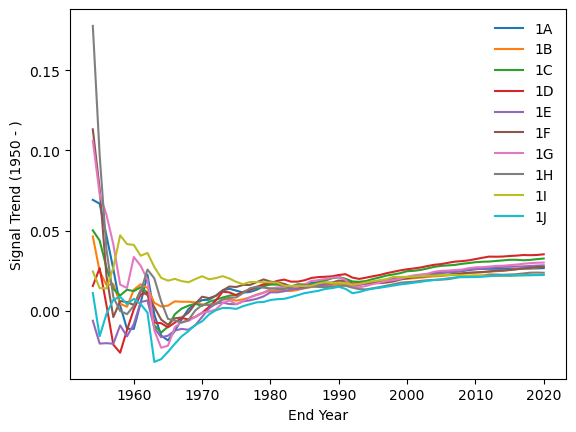

In [16]:
# loop over evaluation models
for model in signal.keys():
    # initialize list to hold trend values
    st = []
    # if model doesn't have data, skip
    if signal[model] == {}:
        continue
    # loop over timescales and retrieve the model signal
    for ts in timescales:
        s = signal[model][ts]
        st.append(s)
    # plot the signal as a function of end year
    plt.plot(end_year, st, label=model)
plt.legend(frameon=False)
plt.xlabel('End Year')
plt.ylabel('Signal Trend (' + str(time[0]) + ' - )')

### Plot signal-to-noise ratio

Last, we compare the magnitude of the trend in the signal (as a function of timescale) to the width of the distribution of unforced trends (noise). Since the noise is the standard deviation in unforced noise trends, the signal-to-noise ratio is significant near ~2. 

The pattern of atmospheric temperature trends through present shows a very(!) large signal to noise ratio, indicating that human influence of the changing thermal structure of our atmosphere is evident.

Text(0, 0.5, 'S/N Ratio')

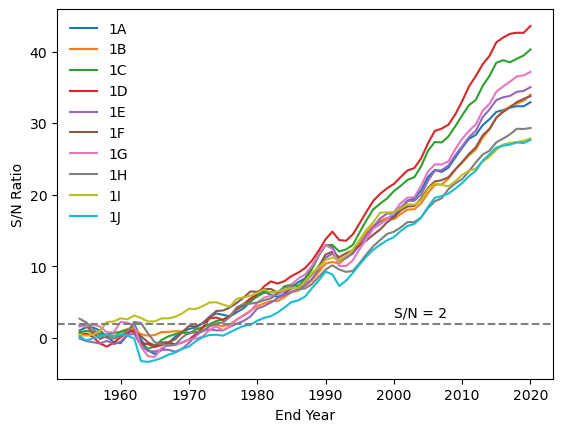

In [17]:
# loop over evaluation models
for model in signal.keys():
    # initialize s/n list
    sn = []
    # skip model if there is no data
    if signal[model] == {}:
        continue
    # loop over time scales
    for ts in timescales:
        # compute s/n ratio from pre-computed
        # signal/noise values
        s = signal[model][ts]
        n = np.std(noise[ts])
        sn.append(s/n)
    # plot s/n ratio as a function of timescale
    plt.plot(end_year, sn, label=model)
plt.axhline(2, linestyle='--', color='gray')
plt.text(2000, 3, "S/N = 2")
plt.legend(frameon=False)
plt.xlabel('End Year')
plt.ylabel('S/N Ratio')

### Discussion Questions

* What part of the atmosphere do you think is most responsible for the large S/N ratios? How could you determine this?
* We have weighted the data by area. Do you know why? Do you think it should be weighted by mass, too? Why or why not?
* This notebook used historical simulation data for the human fingerprint, but historical data includes solar and volcanic changes that are unrelated to humans. How could we better isolate the human fingerprint?
* Different models produce different noise amplitudes. Is this a problem? Why or why not?
* In the signal time series figure, what could cause the variability around the trend?
* Why are the S/N time-series different across models?
* This notebook does not include volcanic and solar variability in the noise term. How would you incorporate these factors in the noise term?
* This notebook shows significant anthropogenic influence on the thermal structure of the atmosphere. What other geophysical fields should be scrutinized for anthropogenic influence?